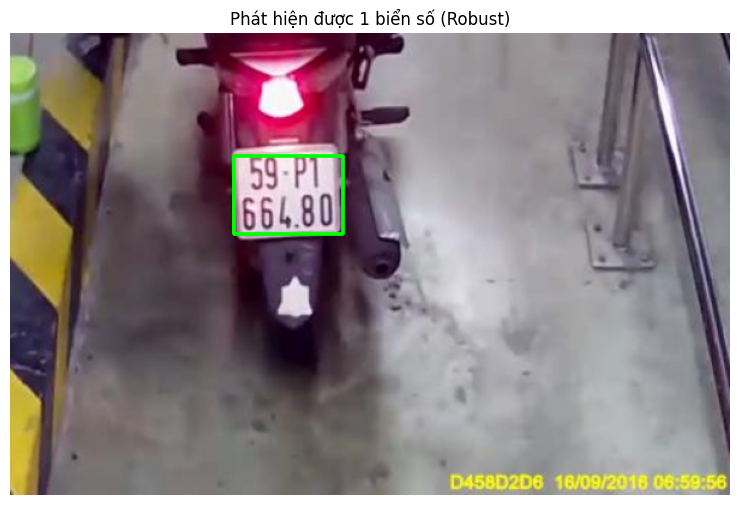

[array([[[190, 162, 208],
         [208, 184, 224],
         [188, 168, 203],
         ...,
         [139, 121, 144],
         [ 76,  57,  82],
         [ 66,  44,  72]],
 
        [[186, 158, 204],
         [207, 183, 223],
         [191, 171, 206],
         ...,
         [146, 128, 151],
         [ 91,  73,  96],
         [ 83,  61,  89]],
 
        [[182, 154, 200],
         [203, 182, 221],
         [192, 175, 209],
         ...,
         [154, 136, 159],
         [110,  92, 115],
         [104,  82, 110]],
 
        ...,
 
        [[ 20,   0,  32],
         [ 53,  32,  64],
         [129, 108, 140],
         ...,
         [182, 160, 188],
         [171, 152, 179],
         [104,  82, 110]],
 
        [[ 15,   0,  26],
         [ 55,  34,  66],
         [133, 113, 142],
         ...,
         [182, 160, 188],
         [152, 130, 158],
         [ 68,  46,  75]],
 
        [[ 21,   0,  32],
         [ 55,  34,  66],
         [122, 102, 131],
         ...,
         [147, 125, 153],
  

In [5]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

def detect_plate_robust(img_path):
    # 1. ĐỌC ẢNH & CHUẨN HÓA KÍCH THƯỚC
    img_original = cv2.imread(img_path)
    if img_original is None: return
    
    # Resize về 600px để ổn định tham số
    target_width = 600
    scale = target_width / img_original.shape[1]
    h_new = int(img_original.shape[0] * scale)
    img = cv2.resize(img_original, (target_width, h_new))
    
    # 2. TIỀN XỬ LÝ CHUNG
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
    # TopHat để làm nổi bật biển số (vùng sáng) trên nền tối
    rectKern = cv2.getStructuringElement(cv2.MORPH_RECT, (13, 5))
    tophat = cv2.morphologyEx(gray, cv2.MORPH_TOPHAT, rectKern)
    
    # Sobel dọc (Chỉ bắt nét dọc) [cite: 230]
    sobelx = cv2.Sobel(tophat, cv2.CV_64F, 1, 0, ksize=3)
    sobelx = np.absolute(sobelx)
    sobelx = (255 * (sobelx / np.max(sobelx))).astype("uint8")
    
    # Otsu Thresholding [cite: 236]
    _, thresh = cv2.threshold(sobelx, 0, 255, cv2.THRESH_BINARY | cv2.THRESH_OTSU)
    
    # 3. CHIẾN LƯỢC MULTI-KERNEL (QUAN TRỌNG NHẤT)
    # Thử 3 loại kernel để bắt mọi trường hợp:
    # - (17, 5): Biển dài chuẩn
    # - (17, 12): Biển vuông (2 dòng) - nối dòng trên dưới
    # - (10, 5): Biển số ở xa/nhỏ
    kernels = [(17, 5), (17, 12), (10, 5)]
    candidates = []

    for k_size in kernels:
        morph_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, k_size)
        # Đóng (Close) để nối liền ký tự
        closed = cv2.morphologyEx(thresh, cv2.MORPH_CLOSE, morph_kernel)
        
        # Tìm contour cho kernel này
        cnts, _ = cv2.findContours(closed, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        
        for c in cnts:
            # Lọc sơ bộ
            x, y, w, h = cv2.boundingRect(c)
            ar = w / float(h)
            if w > 30 and h > 15 and 1.2 <= ar <= 6.0:
                candidates.append((x, y, w, h, closed[y:y+h, x:x+w]))

    # 4. CHẤM ĐIỂM & CHỌN LỌC (SCORING)
    # Loại bỏ các khung trùng nhau và chọn khung tốt nhất
    final_plates = []
    
    # Sắp xếp theo diện tích giảm dần để xử lý vùng lớn trước
    candidates = sorted(candidates, key=lambda x: x[2]*x[3], reverse=True)
    
    merged_mask = np.zeros(gray.shape, dtype="uint8")
    
    for (x, y, w, h, roi_mask) in candidates:
        # Kiểm tra nếu vùng này đã được chọn rồi (tránh trùng lặp do chạy nhiều kernel)
        if merged_mask[y:y+h, x:x+w].mean() > 0:
            continue
            
        # TÍNH ĐIỂM "EDGE DENSITY" (Mật độ cạnh)
        # Biển số thật là vùng trắng đặc trong ảnh nhị phân closed
        white_pixels = cv2.countNonZero(roi_mask)
        total_pixels = w * h
        density = white_pixels / total_pixels
        
        # Biển số thường có mật độ trắng từ 0.3 đến 0.7 (không quá đặc, không quá rỗng)
        if 0.3 < density < 0.8:
            cv2.rectangle(img, (x, y), (x+w, y+h), (0, 255, 0), 2)
            final_plates.append(img_original[int(y/scale):int((y+h)/scale), int(x/scale):int((x+w)/scale)])
            
            # Đánh dấu vùng này đã xử lý
            merged_mask[y:y+h, x:x+w] = 255

    # HIỂN THỊ KẾT QUẢ
    plt.figure(figsize=(10,6))
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.title(f"Phát hiện được {len(final_plates)} biển số (Robust)")
    plt.axis('off')
    plt.show()

    return final_plates

# Chạy thử
detect_plate_robust('0000_00532_b.jpg')

Đang xử lý ảnh: 0000_00532_b.jpg


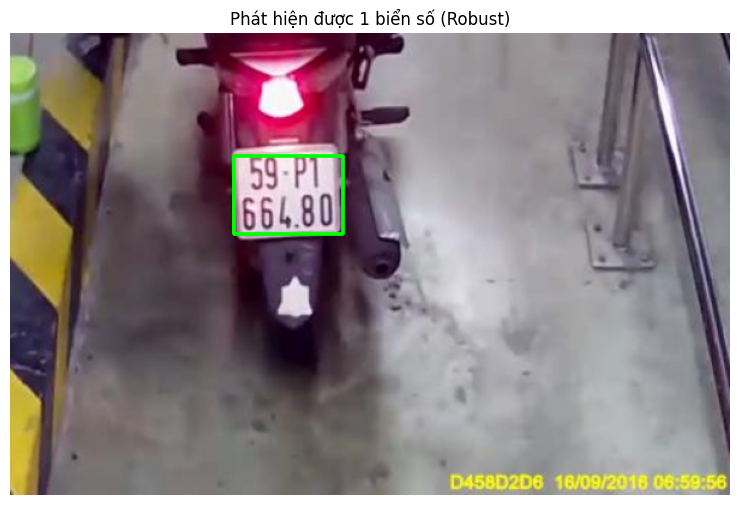


---> Tìm thấy 1 biển số. Bắt đầu tách ký tự...

Đang xử lý biển số thứ 1:


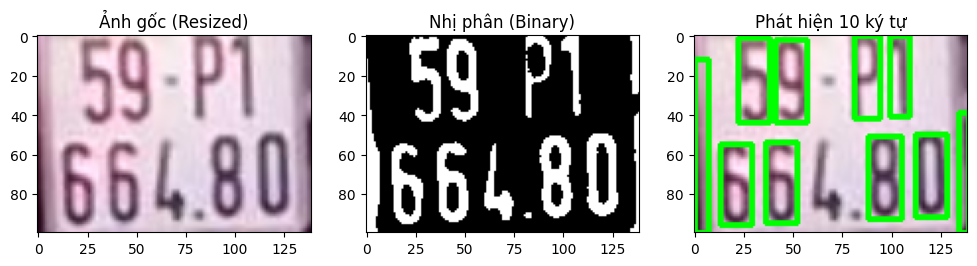

Kết quả: Tách được 10 vùng nghi là ký tự.


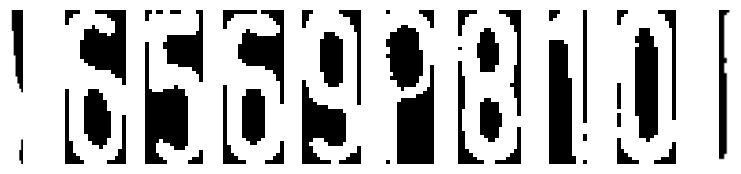

In [7]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os

# ==============================================================================
# 1. HÀM MỚI: XỬ LÝ VÀ TÁCH KÝ TỰ (SEGMENTATION)
# ==============================================================================
def process_and_segment_plate(plate_img):
    """
    Input: Ảnh màu của biển số xe (đã cắt từ bước detect)
    Output: Danh sách các ảnh ký tự đã được cắt rời (đã sort từ trái qua phải)
    """
    # --- A. Tiền xử lý ---
    h, w = plate_img.shape[:2]
    # Resize về chiều cao chuẩn 100px để thuật toán chạy ổn định
    scale = 100 / h
    plate_img_resized = cv2.resize(plate_img, (int(w * scale), 100))
    
    gray = cv2.cvtColor(plate_img_resized, cv2.COLOR_BGR2GRAY)
    
    # Cân bằng sáng (CLAHE) để xử lý bóng râm/chói
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
    gray = clahe.apply(gray)

    # Nhị phân hóa (Otsu)
    # THRESH_BINARY_INV + OTSU: Tự động tìm ngưỡng, đảm bảo chữ Trắng nền Đen
    _, binary = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY_INV | cv2.THRESH_OTSU)
    
    # Kiểm tra lại: Nếu nền đang là trắng (nhiều pixel trắng) thì đảo ngược lại
    if cv2.countNonZero(binary) > binary.size / 2:
        binary = cv2.bitwise_not(binary)

    # --- B. Tìm Contour & Lọc Ký tự ---
    contours, _ = cv2.findContours(binary, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    char_candidates = []
    
    # Copy ảnh để vẽ debug
    debug_img = plate_img_resized.copy()

    for c in contours:
        (x, y, w, h) = cv2.boundingRect(c)
        
        # Các chỉ số hình học
        aspect_ratio = w / float(h)            # Tỷ lệ rộng/cao
        height_ratio = h / float(plate_img_resized.shape[0]) # Tỷ lệ chiều cao so với biển
        area = w * h
        
        # --- BỘ LỌC HEURISTIC (QUAN TRỌNG) ---
        # Giữ lại contour nếu thỏa mãn các điều kiện của ký tự
        keep = False
        
        # Điều kiện chung cho chữ cái/số
        if (0.15 < aspect_ratio < 1.0) and (0.4 < height_ratio < 0.95) and (area > 100):
            keep = True
            
        # Điều kiện riêng cho số '1' hoặc chữ 'I' (mảnh và cao)
        if (aspect_ratio < 0.2) and (height_ratio > 0.45):
            keep = True

        if keep:
            # Padding nhẹ để không mất nét khi cắt
            roi = binary[y:y+h, x:x+w]
            # Resize về kích thước cố định cho model Machine Learning (VD: 30x60)
            # Tuy nhiên ở bước này ta cứ lưu ảnh roi gốc đã
            char_candidates.append((x, roi))
            
            # Vẽ khung xanh lên ảnh debug
            cv2.rectangle(debug_img, (x, y), (x + w, y + h), (0, 255, 0), 2)

    # --- C. Sắp xếp ký tự từ trái qua phải ---
    char_candidates = sorted(char_candidates, key=lambda entry: entry[0])
    chars = [entry[1] for entry in char_candidates]

    # --- Hiển thị quá trình xử lý (Debug) ---
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 3, 1); plt.imshow(plate_img_resized[:,:,::-1]); plt.title("Ảnh gốc (Resized)")
    plt.subplot(1, 3, 2); plt.imshow(binary, cmap='gray'); plt.title("Nhị phân (Binary)")
    plt.subplot(1, 3, 3); plt.imshow(debug_img[:,:,::-1]); plt.title(f"Phát hiện {len(chars)} ký tự")
    plt.show()
    
    return chars

# ==============================================================================
# 2. MAIN EXECUTION (NỐI CODE CŨ VÀ MỚI)
# ==============================================================================

# Đường dẫn ảnh test (Bạn thay đổi ảnh khác ở đây)
img_path_test = '0000_00532_b.jpg'

# BƯỚC 1: GỌI LẠI HÀM DETECT (Để lấy biến final_plates)
# Lưu ý: Hàm detect_plate_robust phải đã được run ở cell trước đó
print(f"Đang xử lý ảnh: {img_path_test}")
try:
    final_plates = detect_plate_robust(img_path_test)
except NameError:
    print("LỖI: Bạn chưa chạy Cell chứa hàm 'detect_plate_robust'. Hãy chạy lại Cell đó trước!")
    final_plates = []

# BƯỚC 2: CHẠY SEGMENTATION TRÊN KẾT QUẢ BƯỚC 1
if final_plates is not None and len(final_plates) > 0:
    print(f"\n---> Tìm thấy {len(final_plates)} biển số. Bắt đầu tách ký tự...")
    
    for i, plate in enumerate(final_plates):
        print(f"\nĐang xử lý biển số thứ {i+1}:")
        
        # Gọi hàm mới viết ở trên
        chars = process_and_segment_plate(plate)
        
        print(f"Kết quả: Tách được {len(chars)} vùng nghi là ký tự.")
        
        # Hiển thị các ký tự đã tách để kiểm tra
        if len(chars) > 0:
            plt.figure(figsize=(10, 2))
            for j, char_img in enumerate(chars):
                plt.subplot(1, len(chars), j+1)
                plt.imshow(char_img, cmap='gray')
                plt.axis('off')
            plt.show()
        else:
            print("Cảnh báo: Không tách được ký tự nào từ biển số này (có thể do mờ/lóa).")
else:
    print("Không tìm thấy biển số nào ở Bước 1. Vui lòng kiểm tra lại ảnh đầu vào.")

In [ ]:
50 xe máy 50 AQUA7_38452_checkoutex_2020-10-24-9-56bCvjjFKTky